# Pré-Análise das Transformações

In [1]:
#@title Configurações iniciais
import pandas as pd
import numpy as np
from ipywidgets import interact

import seaborn as sns
import matplotlib.pyplot as plt

BASE_PATH = 'dados/'

In [2]:
dfx = pd.read_excel(BASE_PATH + 'bolsonaro-preproc2-inputs.xlsx', index_col='ID')
dfx.head()

,Dispositivo Retórico,Main character,Retórica Aristotélica,Tipo de conteúdo,Texto / Hashtag,Tonalidade,Abordagem,Duracao
ID,,,,,,,,
7114971700365691904,Political Statement,Self alone,Pathos,Campaign Act,Hashtag,Neutral,Acclamation,57.93
7115050482179050496,Fact/Statistic,Self alone,Logos,Political-Purposeful,Hashtag,Positive,Acclamation,17.13
7115120078982631424,Commitment,Self + voters,Ethos,Political-Purposeful,Hashtag,Positive,Acclamation,52.54
7115161088219565056,Humor,Self alone,Nenhum,Personal,Hashtag,Positive,Acclamation,34.48
7115207919750253568,Fact/Statistic,Self alone,Logos,Political-Purposeful,Hashtag,Negative,Attack,66.66


In [3]:
dfy = pd.read_excel(BASE_PATH + 'bolsonaro-preproc2-outputs.xlsx', index_col='ID')
dfy.head()

,Curtidas,Curtidas-Log,Curtidas-4Classes,Curtidas-2Classes
ID,,,,
7114971700365691904,24400,10.102338,medium-low,0
7115050482179050496,9163,9.122929,low,0
7115120078982631424,3485,8.156223,low,0
7115161088219565056,22100,10.003333,medium-low,0
7115207919750253568,115700,11.658756,high,1


## 3 -Transformações (One-hot, Target Encoding, Scaler, PCA)

PENSAR:
- setar as 2 classes pelo 75-percentil exato, para ser coerente com a divisão dos dados estratificada

### 3.1 - Separando Dados de Treinamento e Teste

In [4]:
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split

In [5]:
RAND_STATE_SHUFFLE = 37

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, 
                                                    stratify=dfy['Curtidas-4Classes'],
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=RAND_STATE_SHUFFLE)

In [7]:
CATEGORICAL_COLUMNS = ['Dispositivo Retórico', 'Main character', 'Retórica Aristotélica', 'Tipo de conteúdo',
                             'Texto / Hashtag', 'Tonalidade', 'Abordagem']

### 3.2 - One-Hot Enconding

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# It is necessary to pass the categories present in the whole dataset to allow encoding training and/or test data correctly
CATEGORIES = [dfx[col].unique() for col in CATEGORICAL_COLUMNS]

transformers=[
        ('cat', OneHotEncoder(categories=CATEGORIES, drop='first', sparse_output=False), CATEGORICAL_COLUMNS)]

onehot_processor = ColumnTransformer(transformers=transformers, remainder='passthrough')
X_train_dummies = onehot_processor.fit_transform(X_train)

X_train_dummies.shape

(208, 34)

### 3.3 - Target Enconding

In [9]:
TARGET_TYPE = 'continuous'  #'continuous' or 'binary'
LOG_TARGET = False

# CONFIRMAR: melhor foi contínuo sem log ?

In [10]:
transformers=[
        ('cat', TargetEncoder(shuffle=False, target_type=TARGET_TYPE), CATEGORICAL_COLUMNS)]
targetenc_processor = ColumnTransformer(transformers=transformers, remainder='passthrough')


if TARGET_TYPE=='binary':
    X_train_encoded = targetenc_processor.fit_transform(X_train, y_train['Curtidas-2Classes'])
    print("Using binary target!")

elif LOG_TARGET:
    X_train_encoded = targetenc_processor.fit_transform(X_train, y_train['Curtidas-Log'])
    print("Using continuous log-target!")

else:
    X_train_encoded = targetenc_processor.fit_transform(X_train, y_train['Curtidas'])
    print("Using continuous target (without Log)!")


Using continuous target (without Log)!


In [11]:
#targetenc.categories_
targetenc_processor.named_transformers_['cat'].categories_

[array(['Advertisement', 'Collective Appeal', 'Commitment', 'Endorsement',
        'Fact/Statistic', 'Humor', 'Nenhum', 'Opinion', 'Personal Appeal',
        'Political Statement', 'Thanks', 'Urgency'], dtype=object),
 array(['Nenhum', 'Self + Opponent', 'Self + opponent ',
        'Self + supporters (celebridades ou políticos)', 'Self + voters',
        'Self alone', 'Supporters (celebridades ou políticos)', 'Voters'],
       dtype=object),
 array(['Ethos', 'Logos', 'Nenhum', 'Pathos'], dtype=object),
 array(['Campaign Act', 'Nenhum', 'Personal', 'Political-Ideological ',
        'Political-Purposeful'], dtype=object),
 array(['Hashtag', 'Nenhum', 'Texto ', 'Texto + Hashtag'], dtype=object),
 array(['Negative ', 'Neutral', 'Positive '], dtype=object),
 array(['Acclamation', 'Attack', 'Defense'], dtype=object)]

In [12]:
X_train_encoded.shape, X_train.shape

((208, 8), (208, 8))

In [13]:
#X_test_encoded = targetenc_processor.transform(X_test)
#X_test_encoded.shape, X_test.shape

### 3.4 - Target Encoding + Scaler

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [15]:
# Normaliza os dados usando o StandardScaler do scikit-learn
#scaler = StandardScaler()
scaler = MinMaxScaler()

X_train_enc_sc = scaler.fit_transform(X_train_encoded)
#X_test_enc_sc = scaler.transform(X_test_encoded)

### 3.5 - Target Encoding + Scaler + PCA

In [16]:
# Cria uma instância do PCA e aplica aos dados normalizados
pca = PCA()

X_train_enc_sc_pca_full = pca.fit_transform(X_train_enc_sc)

# Determina quantos componentes principais devem ser mantidos
# É a quantidade suficiente para explicar 90% da variação dos dados
explained_variance = pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance)
#num_componentes = np.argmax(cum_var_exp >= 0.8) + 1
num_componentes = np.argmax(cum_explained_variance >= 0.9) + 1  # desempenho menor

In [17]:
# Seleciona os componentes principais e transforma os dados originais
X_train_enc_sc_pca = X_train_enc_sc_pca_full[:, 0:num_componentes]

# Transforma os dados de teste
#X_test_enc_sc_pca = pca.transform(X_test_enc_sc)[:, 0:num_componentes]

# Os dados normalizados e com componentes principais são exibidos
pd.DataFrame(data=X_train_enc_sc_pca, columns=[f'PCA_attr_{i+1}' for i in range(X_train_enc_sc_pca.shape[1])]).head()

,PCA_attr_1,PCA_attr_2,PCA_attr_3,PCA_attr_4,PCA_attr_5,PCA_attr_6,PCA_attr_7
0,-0.099236,-0.281199,0.100490,0.018284,0.143302,-0.026361,0.128112
1,-0.150500,0.324820,-0.061758,-0.020699,0.201880,-0.075583,0.144240
2,-0.088365,-0.277997,0.076131,0.027904,0.141926,-0.010972,0.111440
3,0.273905,-0.025318,0.112542,-0.177298,0.260367,0.214787,-0.052658
4,-0.090808,-0.242951,0.179370,0.044546,-0.038065,-0.052433,0.043269


In [18]:
print("Explicação da variância por cada componente PCA:", *[f'{(100*n):.1f}%' for n in  pca.explained_variance_ratio_])
print("Acumulados:", cum_explained_variance)

Explicação da variância por cada componente PCA: 32.3% 17.8% 11.6% 10.7% 8.9% 7.9% 7.4% 3.4%
Acumulados: [0.32326866 0.5010631  0.61673158 0.72410823 0.81263254 0.89210733
 0.96598902 1.        ]


C:\Users\pablo\AppData\Local\Temp\ipykernel_10544\896675999.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(CATEGORICAL_COLUMNS + ['Duracao'], rotation=45)
C:\Users\pablo\AppData\Local\Temp\ipykernel_10544\896675999.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(CATEGORICAL_COLUMNS + ['Duracao'], rotation=45)


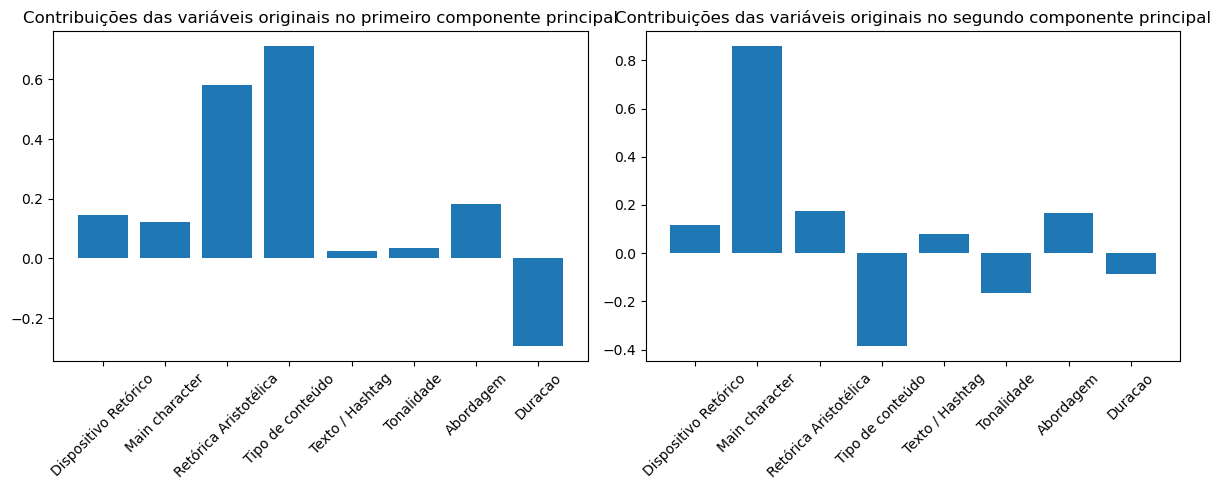

In [20]:
# contributions of the original variables in the first and second components
contributions1 = pca.components_[0]
contributions2 = pca.components_[1]

# create a single figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plot the contributions as a bar plot in the first subplot
axs[0].bar(x=CATEGORICAL_COLUMNS + ['Duracao'], height=contributions1)
axs[0].set_xticklabels(CATEGORICAL_COLUMNS + ['Duracao'], rotation=45)
axs[0].set_title('Contribuições das variáveis originais no primeiro componente principal')

# plot the contributions as a bar plot in the second subplot
axs[1].bar(x=CATEGORICAL_COLUMNS + ['Duracao'], height=contributions2)
axs[1].set_xticklabels(CATEGORICAL_COLUMNS + ['Duracao'], rotation=45)
axs[1].set_title('Contribuições das variáveis originais no segundo componente principal')

# display the figure with subplots
plt.tight_layout()
plt.show()

## 4 - Avaliando em Modelos Básicos

In [21]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import classification_report, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold


In [22]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # SMOTE não funciona com o Pipeline do scikit-learn

In [23]:
def basic_models_evaluation2(X, y, classification=True):
    if classification:
        models = {
            'Logistic Regression': LogisticRegression(random_state=42),
            'Random Forest C': RandomForestClassifier(random_state=42)
        }
        scoring = 'f1'
    else:
        models = {
            #'Linear Regression': LinearRegression(),
            'Lasso': Lasso(random_state=42),
            'Random Forest R': RandomForestRegressor(n_estimators=100, random_state=42)
        }
        scoring = 'r2'

    results = {}
    for model_name, model in models.items():
        if classification:
            # faz um pipeline que aplica o SMOTE e depois treina o modelo
            # a cada passo da validação cruzada
            pipeline_model = Pipeline([
                ('smote', SMOTE(random_state=42)),
                ('classifier', model)
            ])
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RAND_STATE_SHUFFLE)
            #cv_scores = cross_val_score(model, X_t, y_t, cv=cv, scoring=scoring)
            cv_scores = cross_val_score(pipeline_model, X, y, cv=cv, scoring=scoring)
        else:
            cv = KFold(n_splits=5, shuffle=True, random_state=RAND_STATE_SHUFFLE)
            cv_scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
        
        results[model_name] = cv_scores.mean()

    for x in results.keys():
        print(x)
        print(results[x])
        print("-" * 7)

    return results

### 4.1 One-Hot encoding

F1 de classificação:
- sem SMOTE: melhor foi 0.25
- com SMOTE: 0.37 / 0.29

In [27]:
#result = basic_models_evaluation(X_train_dummies, y_train['Curtidas-2Classes'], 
                                 #X_test_dummies, y_test['Curtidas-2Classes'], classification=True)
result = basic_models_evaluation2(X_train_dummies, y_train['Curtidas-2Classes'], classification=True)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Logistic Regression
0.37758565693229945
-------
Random Forest C
0.29190476190476194
-------


In [28]:
#result = basic_models_evaluation(X_train_dummies, y_train['Curtidas'], 
#                                 X_test_dummies, y_test['Curtidas'], classification=False)
result = basic_models_evaluation2(X_train_dummies, y_train['Curtidas'], classification=False)
print('#' * 20)
result = basic_models_evaluation2(X_train_dummies, y_train['Curtidas-Log'], classification=False)

Lasso
-0.2152701588955573
-------
Random Forest R
-0.08030996250512182
-------
####################
Lasso
-0.009866828235626856
-------
Random Forest R
-0.0007154161335948706
-------


### 4.2 Target-Encoding (apenas)

F1 com SMOTE no treinamento: 
- 0.45 / 0.34 (target reg.)
- 0.43 / 0.38 (target binary)
- 0.42 / 0.37 (target regr. com log)

In [29]:
#result = basic_models_evaluation(X_train_encoded, y_train['Curtidas-2Classes'], 
#                                 X_test_encoded, y_test['Curtidas-2Classes'], classification=True)
result = basic_models_evaluation2(X_train_encoded, y_train['Curtidas-2Classes'], classification=True)

Logistic Regression
0.45878839678839684
-------
Random Forest C
0.34831309041835357
-------


In [30]:
#result = basic_models_evaluation(X_train_encoded, y_train['Curtidas'], 
#                                 X_test_encoded, y_test['Curtidas'], classification=False)
result = basic_models_evaluation2(X_train_encoded, y_train['Curtidas'], classification=False)
print('#' * 20)
result = basic_models_evaluation2(X_train_encoded, y_train['Curtidas-Log'], classification=False)

Lasso
-0.11436586999005889
-------
Random Forest R
-0.13100791597779676
-------
####################
Lasso
-0.131010004163653
-------
Random Forest R
-0.0539814315574902
-------


### 4.3 Target-Encoding + Scaler

F1 com SMOTE no treinamento: 
- 0.42 / 0.34 (target regr. log)
- 0.41 / 0.26 (target binary)
- 0.38 / 0.27 (target regr.)

In [31]:
#result = basic_models_evaluation(X_train_enc_sc, y_train['Curtidas-2Classes'], 
#                                 X_test_enc_sc, y_test['Curtidas-2Classes'], classification=True)
result = basic_models_evaluation2(X_train_enc_sc, y_train['Curtidas-2Classes'], classification=True)

Logistic Regression
0.38035164835164836
-------
Random Forest C
0.27376283846872085
-------


In [32]:
#result = basic_models_evaluation(X_train_enc_sc, y_train['Curtidas'], 
#                                 X_test_enc_sc, y_test['Curtidas'], classification=False)
result = basic_models_evaluation2(X_train_enc_sc, y_train['Curtidas'], classification=False)
print('#' * 20)
result = basic_models_evaluation2(X_train_enc_sc, y_train['Curtidas-Log'], classification=False)

Lasso
-0.11432328795966291
-------
Random Forest R
-0.13200568845904254
-------
####################
Lasso
-0.0474770756641405
-------
Random Forest R
-0.053937253238948865
-------


### 4.4 Target-Encoding + Scaler + PCA

F1 classificação com SMOTE: 
- 0.43 / 0.25 (com target binary)
- 0.40 / 0.27 (com target encoding de regressão com o log)

In [33]:
#result = basic_models_evaluation(X_train_enc_sc_pca, y_train['Curtidas-2Classes'], 
#                                 X_test_enc_sc_pca, y_test['Curtidas-2Classes'], classification=True)
result = basic_models_evaluation2(X_train_enc_sc_pca, y_train['Curtidas-2Classes'], classification=True)

Logistic Regression
0.35436392914653786
-------
Random Forest C
0.2749025341130604
-------


In [34]:
#result = basic_models_evaluation(X_train_enc_sc_pca, y_train['Curtidas'], 
#                                 X_test_enc_sc_pca, y_test['Curtidas'], classification=False)
result = basic_models_evaluation2(X_train_enc_sc_pca, y_train['Curtidas'], classification=False)
print('#' * 20)
result = basic_models_evaluation2(X_train_enc_sc_pca, y_train['Curtidas-Log'], classification=False)

Lasso
-0.09711725298515214
-------
Random Forest R
-0.1814213399423882
-------
####################
Lasso
-0.0474770756641405
-------
Random Forest R
-0.06243640131859338
-------
